In [2]:
import os
import sys

import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.graph_objects as go

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum, invert, reconstruct_geometry

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

In [9]:
# Reload the spectra module to ensure we have the latest version
import importlib
importlib.reload(spectra)
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum, invert, reconstruct_geometry, invert_stack_invert, align_points


In [3]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [25]:
from tqdm import tqdm

norm_by_num_neighbors = {i: [] for i in range(1, 6)}

lmax = 4
for local_env in tqdm(local_envs):
    local_env = jnp.array(local_env)
    true_signal = sum_of_diracs(local_env, lmax)
    true_bispectrum = bispectrum(true_signal)
    num_neighbors = len(local_env)
    norm_by_num_neighbors[num_neighbors].append(np.linalg.norm(true_bispectrum))

100%|██████████| 10000/10000 [00:55<00:00, 179.54it/s]


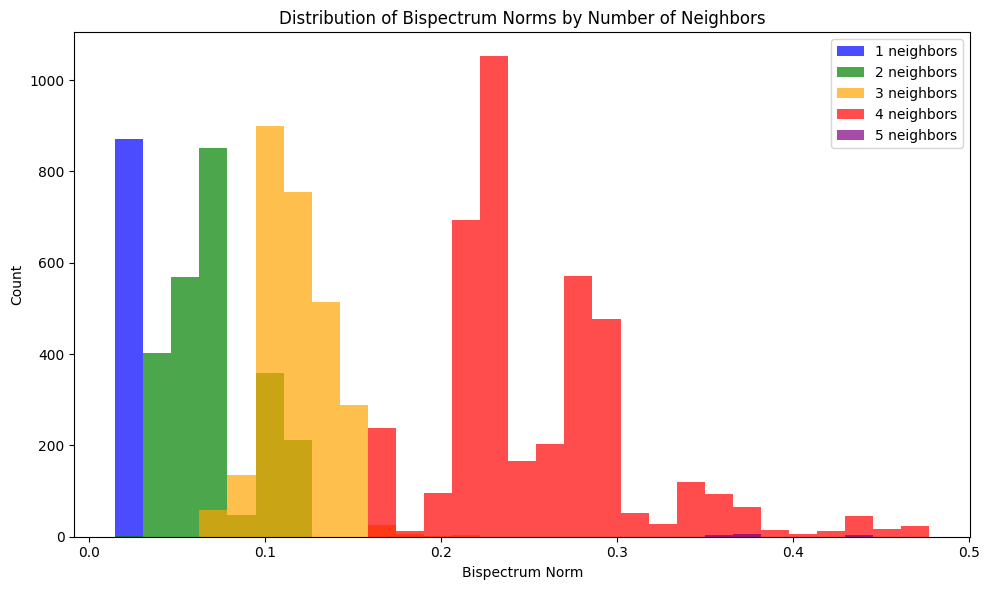

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for different neighbor counts
colors = {
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'red',
    5: 'purple'
}

# Convert the dictionary to lists for plotting
all_norms = []
all_labels = []
for num_neighbors, norms in norm_by_num_neighbors.items():
    all_norms.extend(norms)
    all_labels.extend([num_neighbors] * len(norms))

# Create bins for the histogram
bins = np.linspace(min(all_norms), max(all_norms), 30)

# Plot stacked histogram
for num_neighbors in sorted(norm_by_num_neighbors.keys()):
    norms = norm_by_num_neighbors[num_neighbors]
    if norms:  # Only plot if there are values
        ax.hist(norms, bins=bins, alpha=0.7, label=f'{num_neighbors} neighbors', 
                color=colors[num_neighbors], histtype='bar', stacked=True)

# Add labels and title
ax.set_xlabel('Bispectrum Norm')
ax.set_ylabel('Count')
ax.set_title('Distribution of Bispectrum Norms by Number of Neighbors')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Minimum angle between any two points: 63.43 degrees


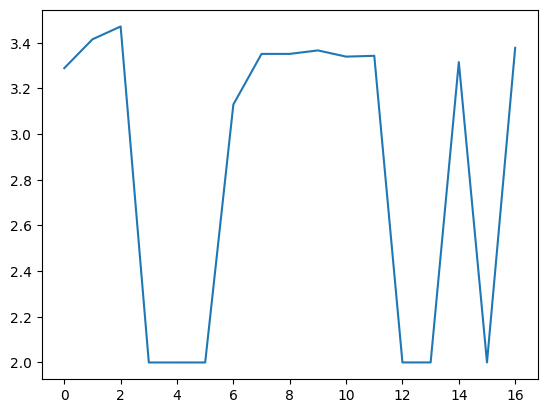

In [37]:
# Calculate the minimum angle between any pair of points
def angle_between_vectors(v1, v2):
    # Normalize vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    # Calculate dot product and clip to avoid numerical errors
    dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
    # Return angle in degrees
    return np.arccos(dot_product) * 180 / np.pi

def min_angle_between_points(geometry):
    """
    Calculate the minimum angle between any two points in a geometry.
    
    Args:
        geometry: Array of points with shape (n, 3)
        
    Returns:
        float: Minimum angle between any two points in degrees
    """
    # Normalize all vectors
    geometry_norm = geometry / np.linalg.norm(geometry, axis=1, keepdims=True)
    
    # Compute all pairwise dot products
    dot_products = np.einsum('ij,kj->ik', geometry_norm, geometry_norm)
    
    # Create a mask for the upper triangle (excluding diagonal)
    mask = np.triu(np.ones_like(dot_products), k=1).astype(bool)
    
    # Get relevant dot products and clip to avoid numerical errors
    relevant_dots = np.clip(dot_products[mask], -1.0, 1.0)
    
    # Calculate all angles and find minimum
    angles = np.arccos(relevant_dots) * 180 / np.pi
    
    return np.min(angles) if len(angles) > 0 else float('inf')

# Calculate minimum angle for degen1
min_angle = min_angle_between_points(icosahedron)
min_lmax = 360 / min_angle
print(f"Minimum angle between any two points: {min_angle:.2f} degrees")

min_lmaxes = []
for local_env in local_envs[:20]:
    if len(local_env) > 1:
        min_angle = min_angle_between_points(jnp.array(local_env))
        min_lmax = 360 / min_angle
        min_lmaxes.append(min_lmax)

plt.plot(min_lmaxes)
plt.show()


In [6]:

def invert_stack_invert(true_spectrum, spectrum_function, lmax, seed=0, initial_points=None,  n_points=20, mask_index=None):
    predicted_points = invert(true_spectrum, spectrum_function, lmax, seed=seed, initial_points=initial_points, n_points=n_points, mask_index=mask_index, learning_rate=1e-2)
    stacked_points = stack_points(predicted_points)
    predicted_points_refined = invert(true_spectrum, spectrum_function, lmax, seed=seed, initial_points=stacked_points, learning_rate=1e-3)
    return predicted_points_refined



def align_points(predicted_points, true_geometry, lmax, learning_rate=1e-3):
    """
    Aligns the predicted points with the true geometry and stacks them.
    """
    predicted_signal = sum_of_diracs(predicted_points, lmax)
    true_signal = sum_of_diracs(true_geometry, lmax) 
    best_initial_quaternion = choose_best_quaternion(predicted_signal, true_signal, num_quaternions=1000)
    quaternion, _, _ = align_signals(predicted_signal, true_signal, best_initial_quaternion, learning_rate=learning_rate)
    rotated_predicted_points = rotate_points_quaternion(quaternion, predicted_points)
    return rotated_predicted_points


def reconstruct_geometry(true_spectrum, spectrum_function, lmax, original_geometry, seed=0, mask_index=None, n_points=None, initial_points=None):
    """
    Reconstructs the geometry from the spectrum.
    """
    predicted_points = invert_stack_invert(true_spectrum, spectrum_function, lmax, seed=seed, mask_index=mask_index, n_points=n_points, initial_points=initial_points)
    rotated_points = align_points(predicted_points, original_geometry, lmax)
    return rotated_points


In [26]:
from tqdm import tqdm

lmax = 6
predicted_geometries = []
avg_errors = []
max_errors = []

dipyramid = jnp.array([
    [ 0.0,       0.0,        1.0      ],  # top
    [ 0.0,       0.0,       -1.0      ],  # bottom
    [ 1.0,       0.0,        0.0      ],  # equator1
    [-0.5,       0.8660254,  0.0      ],  # equator2
    [-0.5,      -0.8660254,  0.0      ]   # equator3
])

key = jax.random.PRNGKey(0)
random_points = jax.random.normal(key, (5, 3))
perturbed_dipyramid = dipyramid + 0.01 *random_points

for true_geometry in tqdm(local_envs[:50]):
    true_geometry = jnp.array(true_geometry)
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    predicted_geometry = invert_stack_invert(true_bispectrum, bispectrum, lmax, n_points=30)
    predicted_geometries.append(predicted_geometry)
    # predicted_geometry = reconstruct_geometry(true_bispectrum, bispectrum, lmax, true_geometry)
    # predicted_geometries.append(predicted_geometry)
    # total_point_distance_error, max_point_distance_error = point_distance(predicted_geometry, true_geometry)
    # avg_point_distance_error = total_point_distance_error / len(predicted_geometry)
    # avg_errors.append(avg_point_distance_error)
    # max_errors.append(max_point_distance_error)

  0%|          | 0/50 [00:00<?, ?it/s]

Final best loss: 6.651595337847847e-05


  2%|▏         | 1/50 [01:56<1:34:59, 116.31s/it]

Final best loss: 1.5686275564836792e-06
Final best loss: 0.00012131717823186577


  4%|▍         | 2/50 [02:15<47:24, 59.26s/it]   

Final best loss: 2.199071271415104e-06
Final best loss: 0.0004190368623332642


  6%|▌         | 3/50 [02:37<33:10, 42.36s/it]

Final best loss: 1.058705589196078e-06
Final best loss: 0.00015400190014044747


  8%|▊         | 4/50 [02:51<23:49, 31.07s/it]

Final best loss: 1.923289629420772e-07
Final best loss: 0.00015400190014044747


 10%|█         | 5/50 [03:04<18:30, 24.68s/it]

Final best loss: 1.923289629420772e-07
Final best loss: 0.00018297230296563776


 12%|█▏        | 6/50 [03:18<15:12, 20.74s/it]

Final best loss: 8.142529683111043e-07
Final best loss: 0.00011060481536148582


 14%|█▍        | 7/50 [03:35<14:03, 19.61s/it]

Final best loss: 3.5676008853361712e-09
Final best loss: 0.0001104791610371432


 16%|█▌        | 8/50 [03:55<13:47, 19.71s/it]

Final best loss: 1.2071707155755958e-06
Final best loss: 8.964826106718045e-05


 18%|█▊        | 9/50 [04:29<16:29, 24.14s/it]

Final best loss: 6.022592538807136e-07
Final best loss: 0.00012777117101303882


 20%|██        | 10/50 [04:42<13:46, 20.66s/it]

Final best loss: 7.141082397631514e-06
Final best loss: 0.00012777117018100093


 22%|██▏       | 11/50 [04:54<11:53, 18.29s/it]

Final best loss: 6.186618561701583e-06
Final best loss: 9.614343816815034e-05


 24%|██▍       | 12/50 [05:06<10:12, 16.13s/it]

Final best loss: 7.824275529968951e-06
Final best loss: 0.00010840771281864148


 26%|██▌       | 13/50 [05:18<09:14, 14.97s/it]

Final best loss: 1.658719816730071e-06
Final best loss: 5.825175535051652e-05


 28%|██▊       | 14/50 [05:28<08:04, 13.46s/it]

Final best loss: 5.004098877153464e-06
Final best loss: 0.0003914488741148869


 30%|███       | 15/50 [05:39<07:25, 12.73s/it]

Final best loss: 1.5589075818866587e-07
Final best loss: 0.00022369720433777822


 32%|███▏      | 16/50 [05:51<07:08, 12.60s/it]

Final best loss: 1.0258024547479818e-07
Final best loss: 9.830252807107823e-05


 34%|███▍      | 17/50 [06:03<06:43, 12.24s/it]

Final best loss: 3.611519099867685e-06
Final best loss: 0.00020764566384272936


 36%|███▌      | 18/50 [06:14<06:20, 11.88s/it]

Final best loss: 1.8006532196193384e-06
Final best loss: 0.00010072107028353381


 38%|███▊      | 19/50 [06:26<06:12, 12.01s/it]

Final best loss: 4.819515716543131e-08
Final best loss: 0.00010024759607260342


 40%|████      | 20/50 [06:38<05:59, 11.99s/it]

Final best loss: 5.82327096411824e-06
Final best loss: 0.00018382919382209319


 42%|████▏     | 21/50 [06:51<05:56, 12.31s/it]

Final best loss: 3.4444351703208043e-06
Final best loss: 0.00012522115602334974


 44%|████▍     | 22/50 [07:04<05:51, 12.54s/it]

Final best loss: 1.940753592689687e-09
Final best loss: 9.115145492944991e-05


 46%|████▌     | 23/50 [07:42<09:06, 20.26s/it]

Final best loss: 4.397470425997852e-06
Final best loss: 0.00010025032880550767


 48%|████▊     | 24/50 [08:00<08:27, 19.52s/it]

Final best loss: 7.438199013139145e-06
Final best loss: 8.8314691238512e-05


 50%|█████     | 25/50 [08:13<07:19, 17.58s/it]

Final best loss: 2.027952574123551e-09
Final best loss: 0.00018552483907366434


 52%|█████▏    | 26/50 [08:29<06:51, 17.13s/it]

Final best loss: 7.496472013060036e-06
Final best loss: 0.0001528635149824529


 54%|█████▍    | 27/50 [08:41<05:58, 15.58s/it]

Final best loss: 8.768375950125084e-06
Final best loss: 7.821606075606268e-05


 56%|█████▌    | 28/50 [08:59<05:56, 16.19s/it]

Final best loss: 7.187092027689962e-06
Final best loss: 6.902678317706194e-05


 58%|█████▊    | 29/50 [09:09<05:04, 14.49s/it]

Final best loss: 6.311715274712142e-07
Final best loss: 0.00016673822029860476


 60%|██████    | 30/50 [09:23<04:46, 14.30s/it]

Final best loss: 2.0438368469669723e-05
Final best loss: 0.00010892338691347839


 62%|██████▏   | 31/50 [09:36<04:21, 13.76s/it]

Final best loss: 5.65872603497937e-07
Final best loss: 0.00011186462841333204


 64%|██████▍   | 32/50 [09:48<03:57, 13.20s/it]

Final best loss: 9.110126538246086e-06
Final best loss: 0.00017201726321049466


 66%|██████▌   | 33/50 [10:03<03:54, 13.77s/it]

Final best loss: 2.1939536688622712e-06
Final best loss: 7.022958670867532e-05


 68%|██████▊   | 34/50 [10:13<03:22, 12.64s/it]

Final best loss: 5.728825519509911e-06
Final best loss: 0.0003311190434687359


 70%|███████   | 35/50 [10:27<03:18, 13.21s/it]

Final best loss: 8.005386229001618e-06
Final best loss: 0.0003204654528605476


 72%|███████▏  | 36/50 [10:41<03:06, 13.32s/it]

Final best loss: 1.0404946127453495e-05
Final best loss: 0.00034418160834899183


 74%|███████▍  | 37/50 [10:55<02:55, 13.48s/it]

Final best loss: 8.844984232583388e-06
Final best loss: 0.0002892605490820579


 76%|███████▌  | 38/50 [11:10<02:47, 13.98s/it]

Final best loss: 7.584839141907751e-06
Final best loss: 0.0002949833611050235


 78%|███████▊  | 39/50 [11:24<02:35, 14.15s/it]

Final best loss: 8.104178811291829e-06
Final best loss: 0.000220424179286731


 80%|████████  | 40/50 [11:39<02:21, 14.15s/it]

Final best loss: 4.781567533872086e-06
Final best loss: 7.67832767531851e-05


 82%|████████▏ | 41/50 [11:48<01:55, 12.87s/it]

Final best loss: 1.2762338257899634e-05
Final best loss: 0.00013761163180771668


 84%|████████▍ | 42/50 [11:59<01:37, 12.23s/it]

Final best loss: 4.223446972192188e-05
Final best loss: 0.00013134593865201904


 86%|████████▌ | 43/50 [12:10<01:22, 11.72s/it]

Final best loss: 1.4688542658110529e-05
Final best loss: 0.0001184367533479977


 88%|████████▊ | 44/50 [12:41<01:45, 17.60s/it]

Final best loss: 4.2325347023156734e-07
Final best loss: 0.00011302568663325745


 90%|█████████ | 45/50 [12:56<01:23, 16.68s/it]

Final best loss: 1.1803116062969452e-05
Final best loss: 0.00018398292035525318


 92%|█████████▏| 46/50 [13:16<01:11, 17.83s/it]

Final best loss: 5.612904983556553e-06
Final best loss: 0.00013304239992606329


 94%|█████████▍| 47/50 [13:28<00:47, 15.94s/it]

Final best loss: 2.106053034562782e-06
Final best loss: 9.764677131816997e-05


 96%|█████████▌| 48/50 [13:59<00:41, 20.70s/it]

Final best loss: 8.497353015861943e-07
Final best loss: 0.0001386367670396944


 98%|█████████▊| 49/50 [14:22<00:21, 21.41s/it]

Final best loss: 8.139990748872255e-06
Final best loss: 0.0002562768549998274


100%|██████████| 50/50 [14:39<00:00, 17.58s/it]

Final best loss: 6.040632844785757e-06


In [27]:
len(true_bispectrum)

35

Average distance from origin (true): 1.2161
Standard deviation of distances (true): 0.1792
Average distance from origin (predicted): 1.1607
Standard deviation of distances (predicted): 0.2783


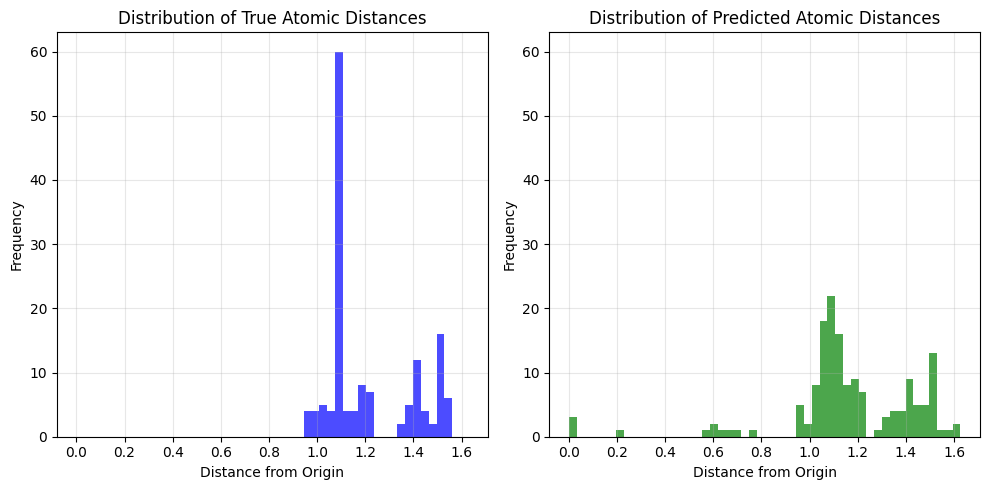

In [28]:
# Stack all local environments into a single array
stacked_true_envs = jnp.vstack([jnp.array(local_env) for local_env in local_envs[:50]])
stacked_pred_envs = jnp.vstack(predicted_geometries)

# Calculate the row-wise norm (Euclidean distance from origin for each point)
true_norms = jnp.linalg.norm(stacked_true_envs, axis=1)
predicted_norms = jnp.linalg.norm(stacked_pred_envs, axis=1)

# Calculate statistics
avg_true_norm = jnp.mean(true_norms)
std_true_norm = jnp.std(true_norms)
avg_pred_norm = jnp.mean(predicted_norms)
std_pred_norm = jnp.std(predicted_norms)

print(f"Average distance from origin (true): {avg_true_norm:.4f}")
print(f"Standard deviation of distances (true): {std_true_norm:.4f}")
print(f"Average distance from origin (predicted): {avg_pred_norm:.4f}")
print(f"Standard deviation of distances (predicted): {std_pred_norm:.4f}")

# Create side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Determine common x and y axis limits
min_x = min(jnp.min(true_norms), jnp.min(predicted_norms))
max_x = max(jnp.max(true_norms), jnp.max(predicted_norms))
bins = 50

# True distances histogram
ax1.hist(true_norms, bins=bins, alpha=0.7, color='blue', range=(min_x, max_x))
ax1.set_xlabel('Distance from Origin')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of True Atomic Distances')
ax1.grid(alpha=0.3)

# Predicted distances histogram
ax2.hist(predicted_norms, bins=bins, alpha=0.7, color='green', range=(min_x, max_x))
ax2.set_xlabel('Distance from Origin')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Predicted Atomic Distances')
ax2.grid(alpha=0.3)

# Get the y-axis limits from both plots and use the same for both
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


Average sum of distances (true): 3.57522
Standard deviation of sum of distances (true): 1.37827
Average sum of distances (predicted): 3.57510
Standard deviation of sum of distances (predicted): 1.37813


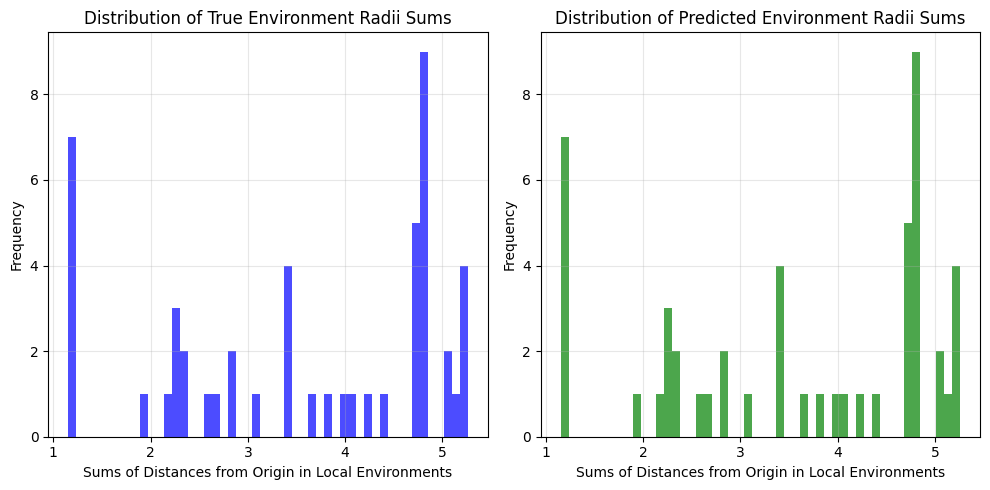

In [30]:
# Calculate the sum of norms for each local environment
true_env_sums = jnp.array([jnp.sum(jnp.linalg.norm(jnp.array(env), axis=1)) for env in local_envs[:50]])
pred_env_sums = jnp.array([jnp.sum(jnp.linalg.norm(geom, axis=1)) for geom in predicted_geometries])

# Calculate statistics
avg_true_sum = jnp.mean(true_env_sums)
std_true_sum = jnp.std(true_env_sums)
avg_pred_sum = jnp.mean(pred_env_sums)
std_pred_sum = jnp.std(pred_env_sums)

print(f"Average sum of distances (true): {avg_true_sum:.5f}")
print(f"Standard deviation of sum of distances (true): {std_true_sum:.5f}")
print(f"Average sum of distances (predicted): {avg_pred_sum:.5f}")
print(f"Standard deviation of sum of distances (predicted): {std_pred_sum:.5f}")

# Create side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Determine common x and y axis limits
min_x = min(jnp.min(true_env_sums), jnp.min(pred_env_sums))
max_x = max(jnp.max(true_env_sums), jnp.max(pred_env_sums))
bins = 50

# True distances histogram
ax1.hist(true_env_sums, bins=bins, alpha=0.7, color='blue', range=(min_x, max_x))
ax1.set_xlabel('Sums of Distances from Origin in Local Environments')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of True Environment Radii Sums')
ax1.grid(alpha=0.3)

# Predicted distances histogram
ax2.hist(pred_env_sums, bins=bins, alpha=0.7, color='green', range=(min_x, max_x))
ax2.set_xlabel('Sums of Distances from Origin in Local Environments')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Predicted Environment Radii Sums')
ax2.grid(alpha=0.3)

# Get the y-axis limits from both plots and use the same for both
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


Average distance from origin (predicted): 1.1847
Standard deviation of distances (predicted): 0.2150


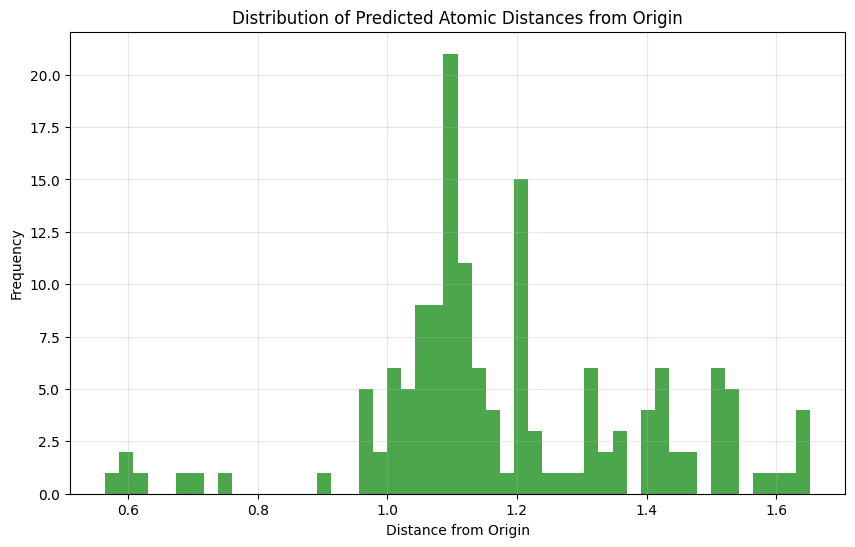

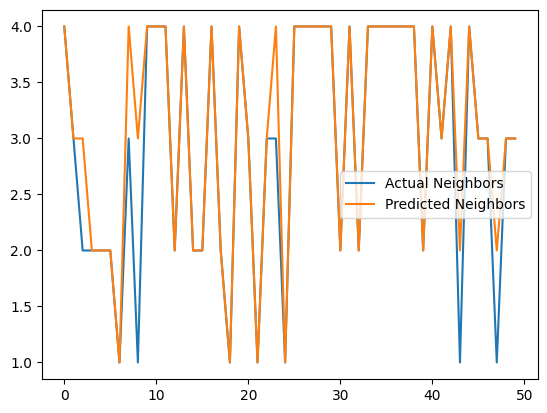

In [31]:
num_actual_neighbors = [len(local_envs[i]) for i in range(len(local_envs[:50]))]
num_predicted_neighbors = [len(predicted_geometries[i]) for i in range(len(predicted_geometries[:50]))]

plt.plot(num_actual_neighbors, label='Actual Neighbors')
plt.plot(num_predicted_neighbors, label='Predicted Neighbors')
plt.legend()

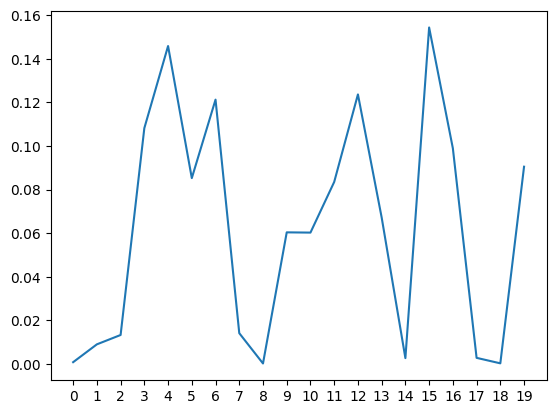

In [25]:
plt.plot(range(len(avg_errors)), avg_errors)
plt.xticks(range(len(avg_errors)))
plt.show()

In [7]:
raise

RuntimeError: No active exception to reraise

In [45]:
predicted_geometries[4]

Array([[-1.19775086e+00, -5.52923443e-02,  2.19209213e-04],
       [ 1.06118703e+00,  4.56758804e-02, -4.11135053e-04]],      dtype=float64)

In [47]:
np.linalg.norm(predicted_geometries[4][0] - jnp.array(local_envs[4])[1])

0.146487016605226

In [48]:
np.linalg.norm(predicted_geometries[4][1] - jnp.array(local_envs[4])[0])

0.14518563553554156

In [49]:
jnp.array(local_envs[3])

Array([[-1.199 ,  0.    ,  0.    ],
       [ 1.0621,  0.    ,  0.    ]], dtype=float64)

In [50]:
visualize_geometry(predicted_geometries[3], show_points=True)

In [51]:
visualize_geometry(jnp.array(local_envs[3]), show_points=True)

In [52]:
plot_points = lambda x: go.Scatter3d(
    x=x[:, 0], 
    y=x[:, 1], 
    z=x[:, 2], 
    mode='markers', 
    marker=dict(size=10)
)

index = 4
go.Figure([
    plot_points(jnp.array(local_envs[index])),
    plot_points(predicted_geometries[index])
])

In [54]:
index = 4

predicted_geometry = predicted_geometries[index]
true_geometry = jnp.array(local_envs[index])

print("Computing point distance error")
total_point_distance_error, max_point_distance_error = point_distance(predicted_geometry, true_geometry)
avg_point_distance_error = total_point_distance_error / len(predicted_geometry)

print(f"Avg error: {round(avg_point_distance_error, 4)} Å")
print(f"Max error: {round(max_point_distance_error, 4)} Å")

Computing point distance error
Avg error: 0.1458 Å
Max error: 0.14650000000000002 Å


In [28]:
def invert_stack_invert(true_spectrum, spectrum_function, lmax, seed=0, initial_points=None,  n_points=20, mask_index=None):
    predicted_points = invert(true_spectrum, spectrum_function, lmax, seed=seed, initial_points=initial_points, n_points=n_points, mask_index=mask_index, learning_rate=1e-2)
    stacked_points = stack_points(predicted_points)
    predicted_points_refined = invert(true_spectrum, spectrum_function, lmax, seed=seed, initial_points=stacked_points, learning_rate=1e-3)
    return predicted_points_refined



def align_points(predicted_points, true_geometry, lmax, learning_rate=1e-3):
    """
    Aligns the predicted points with the true geometry and stacks them.
    """
    predicted_signal = sum_of_diracs(predicted_points, lmax)
    true_signal = sum_of_diracs(true_geometry, lmax) 
    best_initial_quaternion = choose_best_quaternion(predicted_signal, true_signal)
    quaternion, _, _ = align_signals(predicted_signal, true_signal, best_initial_quaternion, learning_rate=learning_rate)
    rotated_predicted_points = rotate_points_quaternion(quaternion, predicted_points)
    return rotated_predicted_points


def reconstruct_geometry(true_spectrum, spectrum_function, lmax, original_geometry, seed=0, mask_index=None, n_points=None, initial_points=None):
    """
    Reconstructs the geometry from the spectrum.
    """
    predicted_points = invert_stack_invert(true_spectrum, spectrum_function, lmax, seed=seed, mask_index=mask_index, n_points=n_points, initial_points=initial_points)
    rotated_points = align_points(predicted_points, original_geometry, lmax)
    return rotated_points

In [29]:
lmax = 5
true_geometry = jnp.array(local_envs[3])
true_signal = sum_of_diracs(true_geometry, lmax)
true_bispectrum = bispectrum(true_signal)
predicted_geometry = reconstruct_geometry(true_bispectrum, bispectrum, lmax, true_geometry)
total_point_distance_error, max_point_distance_error = point_distance(predicted_geometry, true_geometry)
avg_point_distance_error = total_point_distance_error / len(predicted_geometry)
print(avg_point_distance_error, max_point_distance_error)

step 0, loss: 0.22168741185967678
step 100, loss: 0.008693467628203779
step 200, loss: 0.0017327704165120328
step 300, loss: 0.00031880183311828813
Stopping early at step 377: no improvement for 100 iterations
Final best loss: 3.681776778609871e-05
step 0, loss: 3.356946770181909e-05
step 100, loss: 2.938509797983407e-06
Stopping early at step 124: no improvement for 100 iterations
Final best loss: 5.878457970930052e-07
0.002138592881658216 0.0024208300681908958


In [31]:
plot_points = lambda x: go.Scatter3d(
    x=x[:, 0], 
    y=x[:, 1], 
    z=x[:, 2], 
    mode='markers', 
    marker=dict(size=10)
)

go.Figure([
    plot_points(jnp.array(local_envs[3])),
    plot_points(predicted_geometry)
])

In [32]:
print("Computing point distance error")
total_point_distance_error, max_point_distance_error = point_distance(predicted_geometry, true_geometry)
avg_point_distance_error = total_point_distance_error / len(predicted_geometry)

print(f"Avg error: {round(avg_point_distance_error, 4)} Å")
print(f"Max error: {round(max_point_distance_error, 4)} Å")

Computing point distance error
Avg error: 0.0021000000000000003 Å
Max error: 0.0024000000000000002 Å
